In [30]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
)
from tqdm import tqdm

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Data Exploration and key features

In [33]:
# Invoking the prepared data

key_features_winsorkey_features_winsordf = pd.read_csv('all_data.csv')

We see the features:

In [35]:
df.sample()

,CO(GT)_winsor,PT08.S1(CO)_winsor,PT08.S4(NO2)_winsor,T_winsor,RH_winsor,AH_winsor,day_winsor,year_winsor,quarter_winsor,weekday_winsor,NO2(GT)_winsor,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,day,year,quarter,month,weekday,week_year,CO(GT)_winsor.1,PT08.S1(CO)_winsor.1,C6H6(GT)_winsor,PT08.S2(NMHC)_winsor,NOx(GT)_winsor,PT08.S3(NOx)_winsor,NO2(GT)_winsor.1,PT08.S4(NO2)_winsor.1,PT08.S5(O3)_winsor,T_winsor.1,RH_winsor.1,AH_winsor.1,day_winsor.1,year_winsor.1,quarter_winsor.1,month_winsor,weekday_winsor.1,week_year_winsor,air_quality
3742,0.18,0.11,0.56,0.98,0.17,0.73,0.79,0.00,0.79,0.89,0.33,0.70,838.00,4.30,726.00,46.00,1056.00,61.00,1382.00,440.00,35.00,22.40,1.24,13.00,2004.00,3.00,8.00,4.00,33.00,0.70,838.00,4.30,726.00,46.00,1056.00,61.00,1382.00,440.00,35.00,22.40,1.24,13.00,2004.00,3.00,8.00,4.00,33.00,moderate


We now consider the relevant features, i. e., such features that are normalized and transformed as we did in the `exploration data` notebook, and the original data.

In [43]:
key_features_original = [
    "CO(GT)",
    "PT08.S1(CO)",
    "NO2(GT)",
    "PT08.S4(NO2)",
    "T",
    "RH",
    "AH",
    "day",
    "year",
    "quarter",
    "weekday",]

key_features_winsor = [
    "CO(GT)_winsor",
    "PT08.S1(CO)_winsor",
    "PT08.S4(NO2)_winsor",
    "NO2(GT)_winsor", 
    "T_winsor",
    "RH_winsor",
    "AH_winsor",
    "day_winsor",
    "year_winsor",
    "quarter_winsor",
    "weekday_winsor",
]

In [44]:
df_clusters = df[key_features_original+key_features_winsor]

In [45]:
df_clusters.sample(3)

,CO(GT),PT08.S1(CO),NO2(GT),PT08.S4(NO2),T,RH,AH,day,year,quarter,weekday,CO(GT)_winsor,PT08.S1(CO)_winsor,PT08.S4(NO2)_winsor,NO2(GT)_winsor,T_winsor,RH_winsor,AH_winsor,day_winsor,year_winsor,quarter_winsor,weekday_winsor
3232,2.40,1250.00,133.00,1925.00,34.20,28.50,1.51,23.00,2004.00,3.00,4.00,0.66,0.67,0.89,0.76,0.97,0.34,0.86,0.94,0.00,0.79,0.89
7925,2.10,1195.00,203.00,1149.00,6.50,63.10,0.61,3.00,2005.00,1.00,3.00,0.61,0.61,0.37,0.97,0.29,0.86,0.28,0.36,1.00,0.00,0.81
9118,3.40,1446.00,153.00,1706.00,21.70,47.40,1.22,25.00,2005.00,1.00,4.00,0.80,0.87,0.77,0.83,0.81,0.68,0.72,0.96,1.00,0.00,0.89


# K-means model

We first verify that our data satisfies normalization criteria:

In [46]:
df_clusters[key_features_winsor].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT)_winsor,9357.00,0.53,0.24,0.00,0.38,0.54,0.69,1.00
PT08.S1(CO)_winsor,9357.00,0.46,0.25,0.00,0.27,0.45,0.64,1.00
PT08.S4(NO2)_winsor,9357.00,0.58,0.24,0.00,0.45,0.61,0.74,1.00
NO2(GT)_winsor,9357.00,0.62,0.22,0.00,0.52,0.65,0.76,1.00
T_winsor,9357.00,0.67,0.24,0.00,0.57,0.73,0.85,1.00
RH_winsor,9357.00,0.65,0.25,0.00,0.51,0.71,0.85,1.00
AH_winsor,9357.00,0.56,0.26,0.00,0.40,0.58,0.76,1.00
day_winsor,9357.00,0.77,0.24,0.00,0.66,0.85,0.94,1.00
year_winsor,9357.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00
quarter_winsor,9357.00,0.54,0.39,0.00,0.00,0.50,0.79,1.00


Since we are not dealing with other type of data types (besides of numeric), we then consider a K-means model:

In [47]:
# Importing KMeans from sklearn
from sklearn.cluster import KMeans

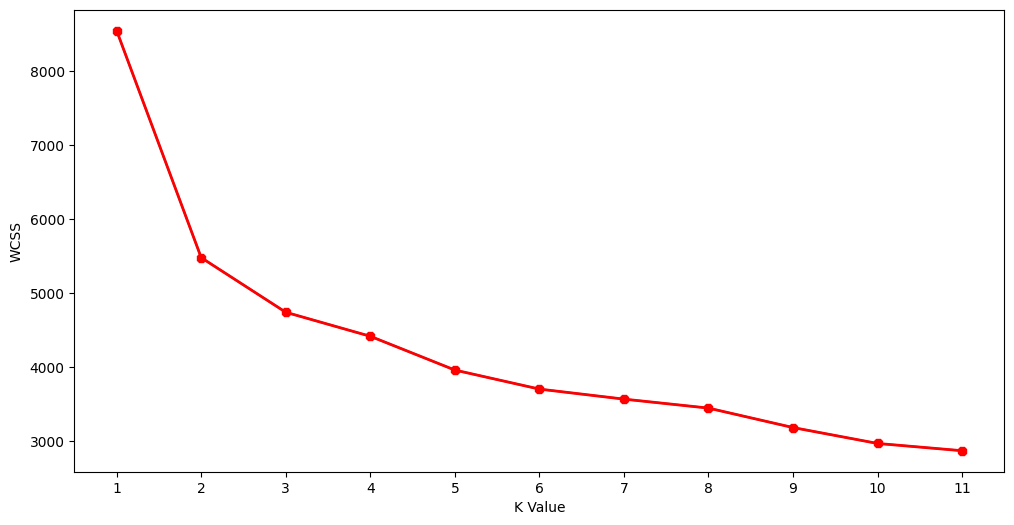

In [93]:
wcss=[]
RANGE = 12

for i in range(1,RANGE):
    km=KMeans(n_clusters=i, init='k-means++', random_state=1492)
    km.fit(df_clusters[key_features_winsor])
    wcss.append(km.inertia_)
    
#The elbow curve
plt.figure(figsize=(12,6))
plt.plot(range(1,RANGE),wcss)
plt.plot(range(1,RANGE),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,RANGE,1))
plt.ylabel("WCSS")
plt.show()

In [94]:
#Taking 5 clusters
km1=KMeans(n_clusters=4, init='random', random_state=1492)
#Fitting the input data
km1.fit(df_clusters[key_features_winsor])

KMeans(init='random', n_clusters=4, random_state=1492)

In [95]:
#predicting the labels of the input data
y=km1.predict(df_clusters[key_features_winsor])

In [96]:
#adding the labels to a column named label
df_clusters["label"] = y

In [97]:
#The new dataframe with the clustering done
df_clusters.head()

,CO(GT),PT08.S1(CO),NO2(GT),PT08.S4(NO2),T,RH,AH,day,year,quarter,weekday,CO(GT)_winsor,PT08.S1(CO)_winsor,PT08.S4(NO2)_winsor,NO2(GT)_winsor,T_winsor,RH_winsor,AH_winsor,day_winsor,year_winsor,quarter_winsor,weekday_winsor,label
0,2.60,1360.00,113.00,1692.00,13.60,48.90,0.76,10.00,2004.00,1.00,2.00,0.69,0.79,0.76,0.67,0.62,0.70,0.41,0.72,0.00,0.00,0.69,3
1,2.00,1292.00,92.00,1559.00,13.30,47.70,0.73,10.00,2004.00,1.00,2.00,0.59,0.72,0.68,0.56,0.61,0.69,0.38,0.72,0.00,0.00,0.69,3
2,2.20,1402.00,114.00,1555.00,11.90,54.00,0.75,10.00,2004.00,1.00,2.00,0.63,0.83,0.67,0.68,0.56,0.76,0.40,0.72,0.00,0.00,0.69,3
3,2.20,1376.00,122.00,1584.00,11.00,60.00,0.79,10.00,2004.00,1.00,2.00,0.63,0.81,0.69,0.71,0.53,0.83,0.43,0.72,0.00,0.00,0.69,3
4,1.60,1272.00,116.00,1490.00,11.20,59.60,0.79,10.00,2004.00,1.00,2.00,0.49,0.70,0.63,0.69,0.54,0.82,0.43,0.72,0.00,0.00,0.69,3


# Analysis

In [183]:
df_analysis = df_clusters[key_features_original+['label']]

In [184]:
df_analysis.sample(3)

,CO(GT),PT08.S1(CO),NO2(GT),PT08.S4(NO2),T,RH,AH,day,year,quarter,weekday,label
5348,1.80,1174.00,109.00,1596.00,22.00,54.00,1.41,19.00,2004.00,4.00,1.00,3
123,4.20,1595.00,145.00,2058.00,16.70,57.40,1.08,15.00,2004.00,1.00,0.00,1
240,2.30,1452.00,110.00,1774.00,18.50,46.30,0.97,20.00,2004.00,1.00,5.00,3


In [185]:
df_analysis.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.00,2.09,1.32,0.10,1.20,1.80,2.60,11.90
PT08.S1(CO),9357.00,1098.39,212.91,647.00,941.00,1063.00,1221.00,2040.00
NO2(GT),9357.00,112.37,43.95,2.00,86.00,109.00,133.00,340.00
PT08.S4(NO2),9357.00,1456.53,339.37,551.00,1242.00,1463.00,1662.00,2775.00
T,9357.00,18.30,8.66,-1.90,12.00,17.80,24.10,44.60
RH,9357.00,49.25,16.97,9.20,36.60,49.60,61.90,88.70
AH,9357.00,1.02,0.40,0.18,0.75,1.00,1.30,2.23
day,9357.00,15.88,8.81,1.00,8.00,16.00,23.00,31.00
year,9357.00,2004.24,0.43,2004.00,2004.00,2004.00,2004.00,2005.00
quarter,9357.00,2.42,1.13,1.00,1.00,2.00,3.00,4.00


In [186]:
df_analysis[df_analysis['label']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),2247.00,2.04,1.34,0.10,1.10,1.80,2.70,8.70
PT08.S1(CO),2247.00,1107.11,200.84,715.00,958.00,1063.00,1222.00,1846.00
NO2(GT),2247.00,141.07,50.68,17.00,109.00,138.00,173.00,340.00
PT08.S4(NO2),2247.00,1163.97,272.23,551.00,948.00,1134.00,1366.50,2147.00
T,2247.00,10.50,5.85,-1.90,5.60,9.80,14.30,30.00
RH,2247.00,52.26,16.03,9.90,40.80,50.90,64.75,86.60
AH,2247.00,0.67,0.26,0.18,0.45,0.66,0.90,1.39
day,2247.00,15.02,8.92,1.00,7.00,15.00,23.00,31.00
year,2247.00,2005.00,0.00,2005.00,2005.00,2005.00,2005.00,2005.00
quarter,2247.00,1.04,0.19,1.00,1.00,1.00,1.00,2.00


In [187]:
df_analysis[df_analysis['label']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),1026.00,1.99,1.24,0.10,1.30,1.80,2.40,9.90
PT08.S1(CO),1026.00,1066.40,216.73,676.00,904.50,1023.00,1175.00,2040.00
NO2(GT),1026.00,101.55,37.73,5.00,79.25,109.00,115.00,269.00
PT08.S4(NO2),1026.00,1524.62,315.93,783.00,1315.00,1500.50,1731.75,2679.00
T,1026.00,20.48,7.77,2.60,14.53,19.70,25.48,41.40
RH,1026.00,46.60,16.75,12.90,33.02,46.40,60.30,84.20
AH,1026.00,1.08,0.36,0.33,0.82,1.08,1.34,2.07
day,1026.00,16.48,8.66,1.00,9.00,17.00,24.00,31.00
year,1026.00,2004.00,0.00,2004.00,2004.00,2004.00,2004.00,2004.00
quarter,1026.00,2.86,0.94,1.00,2.00,3.00,4.00,4.00


In [188]:
df_analysis[df_analysis['label']==2].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),2852.00,1.26,0.55,0.10,0.80,1.30,1.80,4.30
PT08.S1(CO),2852.00,933.36,98.72,647.00,861.00,934.00,1005.00,1285.00
NO2(GT),2852.00,80.71,28.82,2.00,58.00,79.00,109.00,196.00
PT08.S4(NO2),2852.00,1345.63,202.67,682.00,1239.00,1379.00,1481.25,1836.00
T,2852.00,18.83,7.57,1.20,13.40,18.00,23.40,42.20
RH,2852.00,51.58,16.70,10.00,40.60,51.60,63.92,87.20
AH,2852.00,1.10,0.38,0.20,0.86,1.05,1.37,2.18
day,2852.00,16.43,8.62,1.00,10.00,16.00,24.00,31.00
year,2852.00,2004.00,0.00,2004.00,2004.00,2004.00,2004.00,2004.00
quarter,2852.00,2.94,0.91,1.00,2.00,3.00,4.00,4.00


In [189]:
df_analysis[df_analysis['label']==3].describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),3232.00,2.88,1.35,1.20,1.80,2.40,3.50,11.90
PT08.S1(CO),3232.00,1248.12,181.33,903.00,1104.00,1214.00,1358.00,2008.00
NO2(GT),3232.00,123.80,31.59,27.00,108.00,113.00,138.00,288.00
PT08.S4(NO2),3232.00,1736.17,252.99,1053.00,1564.75,1702.50,1881.00,2775.00
T,3232.00,22.56,7.83,1.40,16.90,22.00,27.70,44.60
RH,3232.00,45.94,17.21,9.20,31.80,46.80,58.20,88.70
AH,3232.00,1.18,0.34,0.30,0.93,1.13,1.45,2.23
day,3232.00,15.79,8.90,1.00,8.00,16.00,23.00,31.00
year,3232.00,2004.00,0.00,2004.00,2004.00,2004.00,2004.00,2004.00
quarter,3232.00,2.79,0.96,1.00,2.00,3.00,4.00,4.00


In [190]:
analysis = 'analysis.csv'

In [191]:
df_analysis.to_csv(analysis, index=False)

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_with_categorical(df, features, categorical_var):
    size = len(features)
    
    # Create a figure with subplots in a single row
    fig, axes = plt.subplots(1, size, figsize=(7 * size, 5), dpi=100)

    # Ensure axes is iterable, even if there's only one subplot
    if size == 1:
        axes = [axes]
    
    # Loop through each feature and create a displot
    for i, feature in enumerate(features):
        sns.histplot(df, x=feature, hue=categorical_var, kde=True, fill=True, ax=axes[i])
        
        # Set the title and labels for each subplot
        axes[i].set_title(f'{feature} by {categorical_var}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.show()

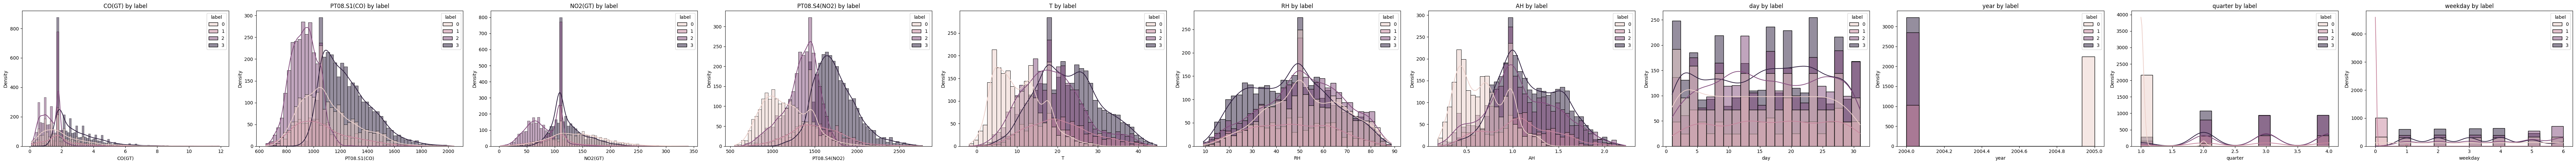

In [146]:
plot_features_with_categorical(df_clusters, key_features_original, 'label')

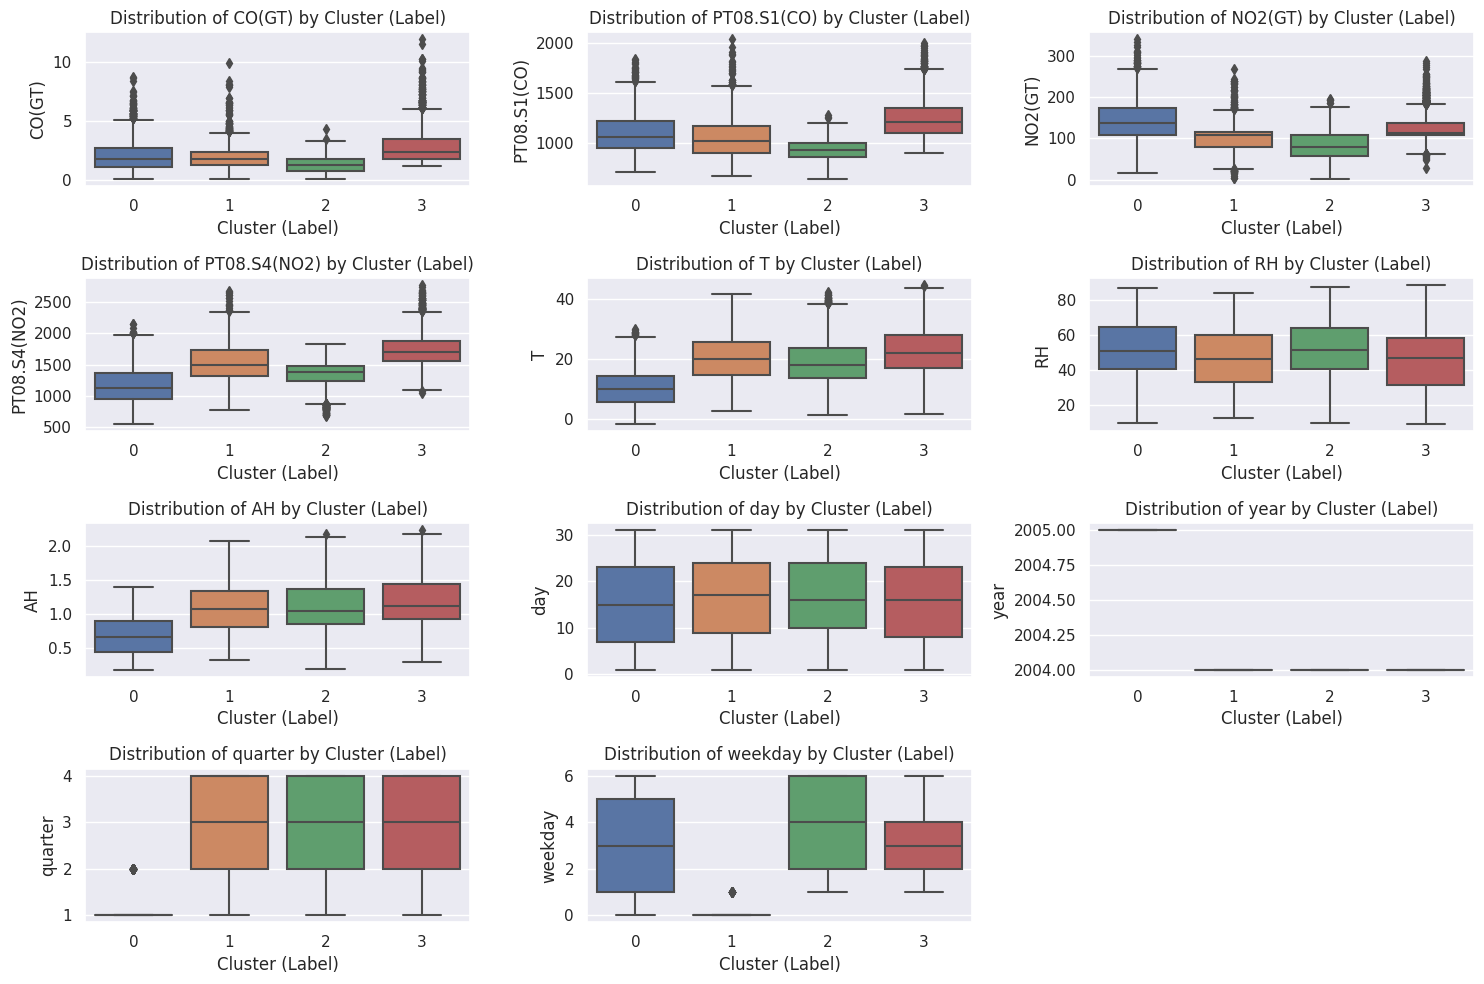

In [200]:
plt.figure(figsize=(15, 10))

# Select a subset of variables for visualization
variables_to_plot = key_features_original

# Create a boxplot for each variable, showing distribution by label (cluster)
for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='label', y=var, data=df_clusters)
    plt.title(f'Distribution of {var} by Cluster (Label)')
    plt.xlabel('Cluster (Label)')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

# PCA Visualizations

Now we visualize the segmentation of the data via principal components. In this case, for simplicity, we take the two principal components that contain the most information about the total variance. The first principal component captures the maximum possible variance in the data, while the second captures the next highest amount of variance. Both are orthogonal to each other.

In [99]:
list_labels = list(df_clusters['label'].drop_duplicates())

In [118]:
for number in range(len(list_labels)):
    print(df_clusters[df_clusters['label']==number].shape[0])

2247
1026
2852
3232


In [101]:
from sklearn.decomposition import PCA

In [170]:
components = df_clusters[key_features_winsor].shape[1]

In [209]:
pca = PCA(components)
data = pca.fit_transform(df_clusters[key_features_winsor])

In [210]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1

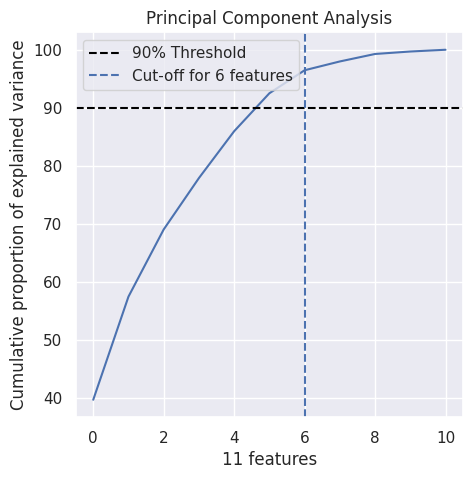

In [219]:
# Plot the graph
plt.figure(figsize=(5, 5))
plt.plot(cumsum*100)

# Add horizontal lines
plt.axhline(y=90, color='black', linestyle='--', label='90% Threshold')

# Add vertical lines
plt.axvline(x=d, color='b', linestyle='--', label=f'Cut-off for {d} features')

# Add labels and legend
plt.xlabel(f'{components} features')
plt.ylabel('Cumulative proportion of explained variance')
plt.title('Principal Component Analysis')
plt.legend()

# Show plot
plt.grid(True)
#plt.savefig('pca.png', dpi=100, bbox_inches="tight")
plt.show()

Then, it is only necessary to consider $5$ features in order to have at least $90\%$ of the information associated to the variance of the original data

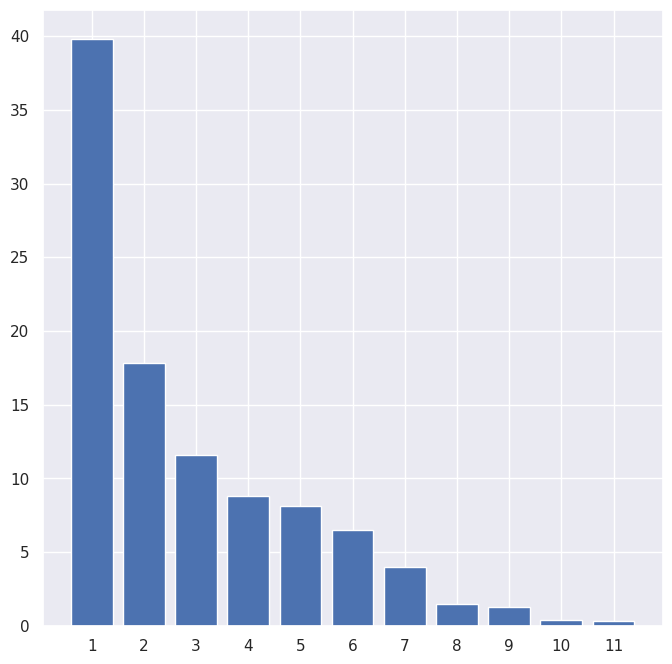

In [217]:
plt.figure(figsize=(8,8))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1, len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.show()

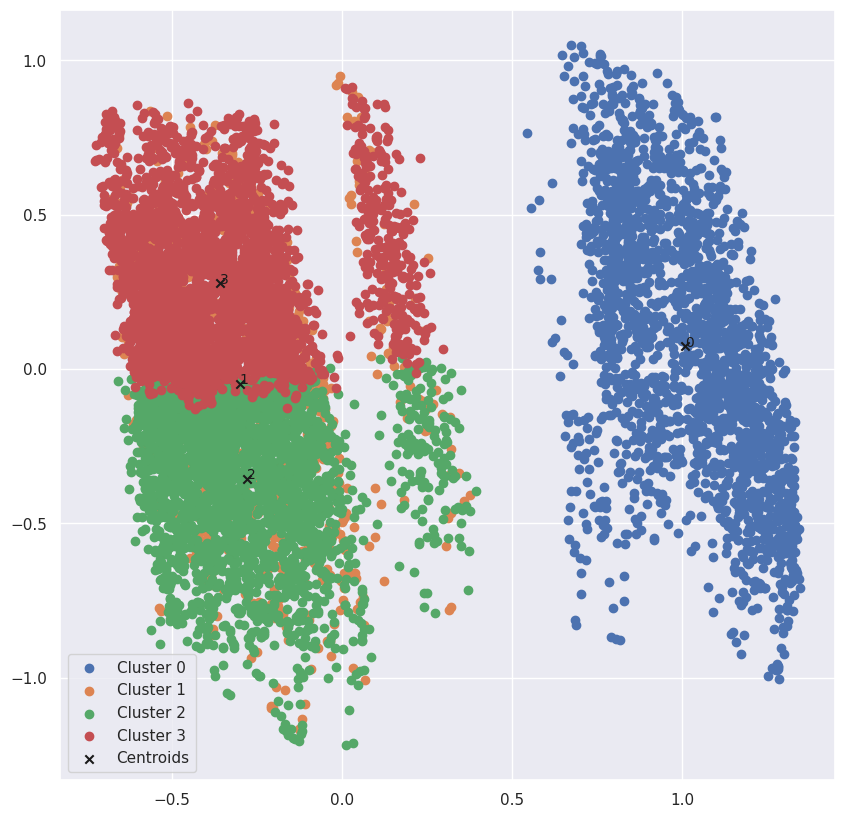

In [216]:
centers = np.array(km1.cluster_centers_)
# KMeans clustering
#model = KMeans(n_clusters=7, init="k-means++")
model = KMeans(n_clusters=len(list_labels), init="random", random_state=1492)

label = model.fit_predict(data)
centers = np.array(model.cluster_centers_)

# Plotting
plt.figure(figsize=(10, 10))
uniq = np.unique(label)

for i in uniq:
    plt.scatter(data[label == i, 0], data[label == i, 1], label=f'Cluster {i}')

plt.scatter(centers[:, 0], centers[:, 1], marker="x", color='k', label='Centroids')

# Annotating cluster points with labels
for i, txt in enumerate(uniq):
    plt.annotate(txt, (centers[i, 0], centers[i, 1]), fontsize=10, color='k')

plt.legend()
plt.show()

## Two Principal Components

In [220]:
pca = PCA(2)
data = pca.fit_transform(df_clusters[key_features_winsor])

In [221]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1

Then, it is only necessary to consider $5$ features in order to have at least $90\%$ of the information associated to the variance of the original data

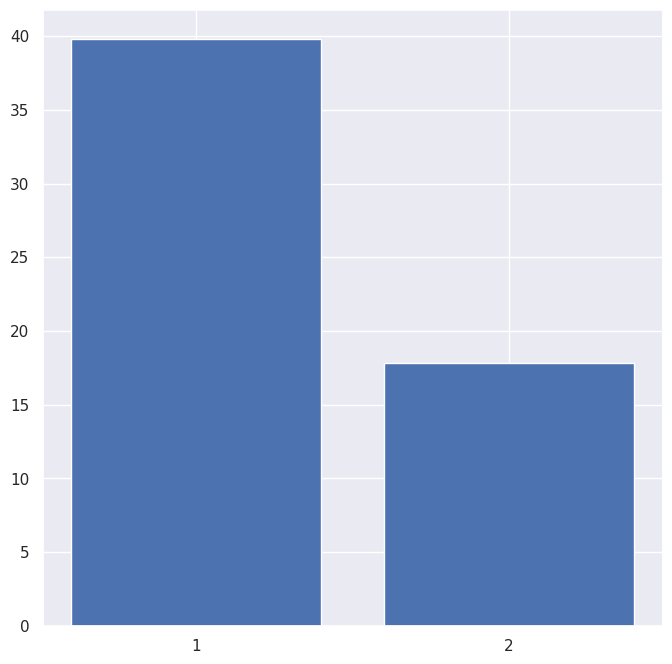

In [223]:
plt.figure(figsize=(8,8))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1, len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.show()

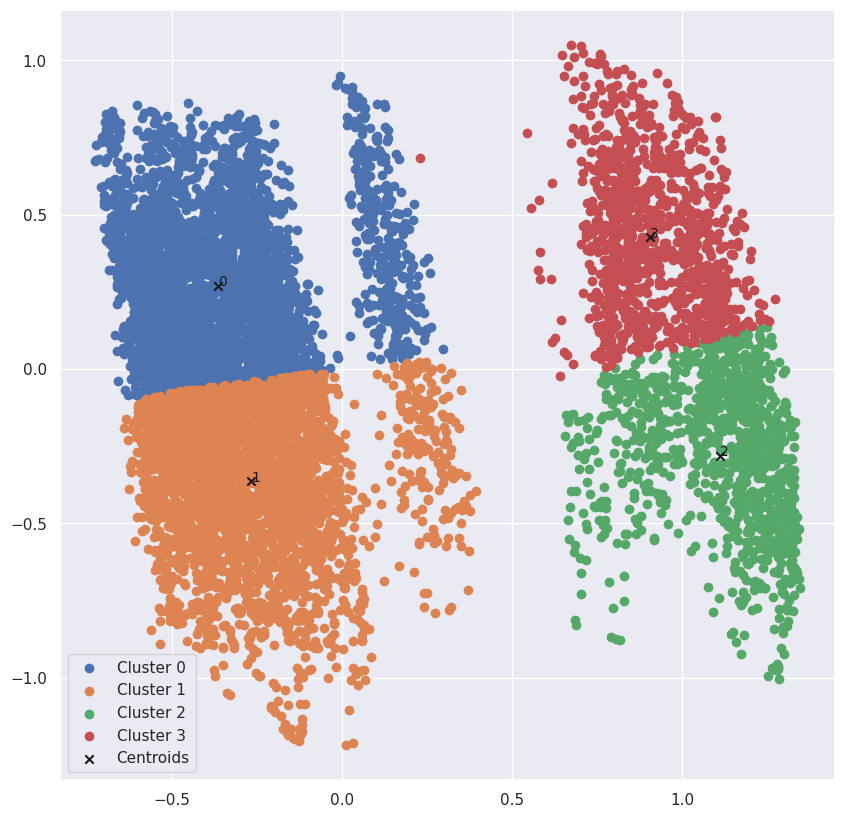

In [224]:
centers = np.array(km1.cluster_centers_)
# KMeans clustering
#model = KMeans(n_clusters=7, init="k-means++")
model = KMeans(n_clusters=len(list_labels), init="random", random_state=1492)

label = model.fit_predict(data)
centers = np.array(model.cluster_centers_)

# Plotting
plt.figure(figsize=(10, 10))
uniq = np.unique(label)

for i in uniq:
    plt.scatter(data[label == i, 0], data[label == i, 1], label=f'Cluster {i}')

plt.scatter(centers[:, 0], centers[:, 1], marker="x", color='k', label='Centroids')

# Annotating cluster points with labels
for i, txt in enumerate(uniq):
    plt.annotate(txt, (centers[i, 0], centers[i, 1]), fontsize=10, color='k')

plt.legend()
plt.show()